In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from pydl85 import DL85Predictor
from pydl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils as utils
import graphviz
import relabeling_fairlearn

In [2]:
FILE_NAME = "relab_Lawsuit"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [3]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [4]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df

,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [5]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
utils.discrimination(y, sensitive)

-0.31205112598904444

In [6]:
for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1
utils.discrimination(y, sensitive)

0.31205112598904444

In [7]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [8]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=7, random_state=0)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),6)
print("Accuracy DL8.5 on training set =", accuracy_train)
discrimation_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 6)
print("Discrimination of classifier on train(pred)", discrimation_train_pred)

Accuracy DL8.5 on training set = 0.923445
Discrimination of classifier on train(pred) 0.294


[Text(0.4880952380952381, 0.9375, 'X[10] <= 0.5\ngini = 0.479\nsamples = 209\nvalue = [126, 83]'),
 Text(0.44047619047619047, 0.8125, 'X[9] <= 0.5\ngini = 0.41\nsamples = 177\nvalue = [126, 51]'),
 Text(0.19047619047619047, 0.6875, 'X[1] <= 0.5\ngini = 0.147\nsamples = 113\nvalue = [104, 9]'),
 Text(0.14285714285714285, 0.5625, 'gini = 0.0\nsamples = 52\nvalue = [52, 0]'),
 Text(0.23809523809523808, 0.5625, 'X[4] <= 0.5\ngini = 0.252\nsamples = 61\nvalue = [52, 9]'),
 Text(0.14285714285714285, 0.4375, 'X[2] <= 0.5\ngini = 0.102\nsamples = 37\nvalue = [35, 2]'),
 Text(0.09523809523809523, 0.3125, 'X[8] <= 0.5\ngini = 0.219\nsamples = 16\nvalue = [14, 2]'),
 Text(0.047619047619047616, 0.1875, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.14285714285714285, 0.1875, 'gini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.19047619047619047, 0.3125, 'gini = 0.0\nsamples = 21\nvalue = [21, 0]'),
 Text(0.3333333333333333, 0.4375, 'X[8] <= 0.5\ngini = 0.413\nsamples = 24\nvalue = [17, 7]'

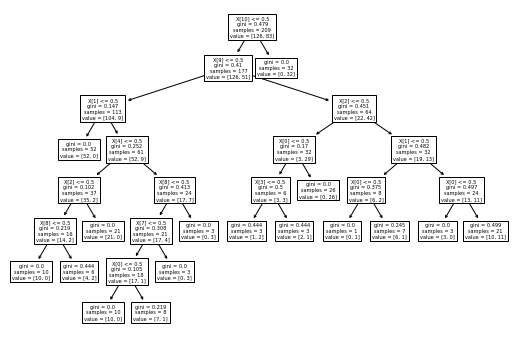

In [9]:
from sklearn import tree
tree.plot_tree(clf)

In [10]:
leafs = list()
cnt = np.unique(sensitive_train, return_counts=True)[1]
relabeling_fairlearn.get_leaves_candidates(clf, X_train, y_train, sensitive_train, cnt, len(y_train), leafs)


In [11]:
leafs_relab = relabeling_fairlearn.leaves_to_relabel(clf, X_train, y_train, y_pred_train, sensitive_train, 0.1)
print()
sum_acc = 0
sum_disc = 0
for l in leafs_relab:
    print(l)
    print()
    sum_acc += l.acc
    sum_disc += l.disc
sum_acc = round(sum_acc, 6)
sum_disc = round(sum_disc, 6)


Path: format -> (node id, feature, way)
((0, 10, 'left'), (1, 9, 'right'), (17, 2, 'right'), (23, 1, 'left'), (24, 0, 'right'), (26, -2, 'leaf')) 
node_id: 26 
The effect of relabeling the leaf on accuracy: -0.02392344497607655
The effect of relabeling the leaf on discrimination: -0.04352380952380953 
ratio: 1.8192952380952385 
contingency table: 
[0.019138755980861243, 0.004784688995215311]
[0.009569377990430622, 0.0]
transactions: [138, 150, 155, 163, 164, 170, 172]

Path: format -> (node id, feature, way)
((0, 10, 'left'), (1, 9, 'right'), (17, 2, 'left'), (18, 0, 'left'), (19, 3, 'left'), (20, -2, 'leaf')) 
node_id: 20 
The effect of relabeling the leaf on accuracy: -0.004784688995215311
The effect of relabeling the leaf on discrimination: -0.023999999999999997 
ratio: 5.016 
contingency table: 
[0.0, 0.0]
[0.004784688995215311, 0.009569377990430622]
transactions: [114, 116, 145]

Path: format -> (node id, feature, way)
((0, 10, 'left'), (1, 9, 'right'), (17, 2, 'right'), (23, 1, 

In [12]:
clf.tree_.value[4]

array([[52.,  9.]])

In [13]:
for leaf in leafs_relab:
    relabeling_fairlearn.browse_and_relab(clf, leaf.node_id)


In [14]:

y_pred_train = clf.predict(X_train)
accuracy_train_relab = round(accuracy_score(y_train, y_pred_train), 6)
discrimation_train_pred_relab = round(utils.discrimination(y_pred_train, sensitive_train), 6)
new_acc= round(accuracy_train+sum_acc, 6)
new_disc = round(discrimation_train_pred+sum_disc, 6)
print(f"Accuracy:\n"
    f"    Before      : {accuracy_train}\n"
    f"    Leafs       : {sum_acc}\n"
    f"    After       : {accuracy_train_relab}\n"
    f"    Expected    : {new_acc}\n"
    f"    Check       : {new_acc == accuracy_train_relab}")
print(f"Discrim:\n"
    f"    Before      : {discrimation_train_pred}\n"
    f"    Leafs       : {sum_disc }\n"
    f"    After       : {discrimation_train_pred_relab}\n"
    f"    Expected    : {new_disc}\n"
    f"    Check       : {new_disc== discrimation_train_pred_relab}")

Accuracy:
    Before      : 0.923445
    Leafs       : -0.148325
    After       : 0.77512
    Expected    : 0.77512
    Check       : True
Discrim:
    Before      : 0.294
    Leafs       : -0.25
    After       : 0.044
    Expected    : 0.044
    Check       : True


[Text(0.4880952380952381, 0.9375, 'X[10] <= 0.5\ngini = 0.479\nsamples = 209\nvalue = [126, 83]'),
 Text(0.44047619047619047, 0.8125, 'X[9] <= 0.5\ngini = 0.41\nsamples = 177\nvalue = [126, 51]'),
 Text(0.19047619047619047, 0.6875, 'X[1] <= 0.5\ngini = 0.147\nsamples = 113\nvalue = [104, 9]'),
 Text(0.14285714285714285, 0.5625, 'gini = 0.0\nsamples = 52\nvalue = [52, 0]'),
 Text(0.23809523809523808, 0.5625, 'X[4] <= 0.5\ngini = 0.252\nsamples = 61\nvalue = [52, 9]'),
 Text(0.14285714285714285, 0.4375, 'X[2] <= 0.5\ngini = 0.102\nsamples = 37\nvalue = [35, 2]'),
 Text(0.09523809523809523, 0.3125, 'X[8] <= 0.5\ngini = 0.219\nsamples = 16\nvalue = [14, 2]'),
 Text(0.047619047619047616, 0.1875, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.14285714285714285, 0.1875, 'gini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.19047619047619047, 0.3125, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]'),
 Text(0.3333333333333333, 0.4375, 'X[8] <= 0.5\ngini = 0.413\nsamples = 24\nvalue = [17, 7]'

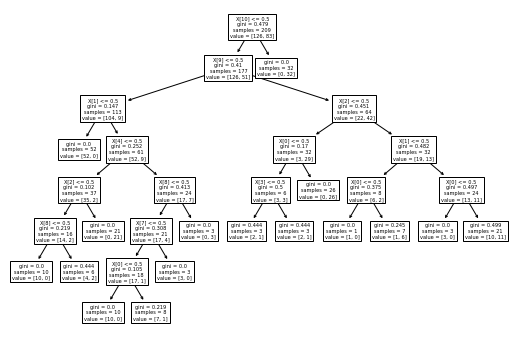

In [15]:
tree.plot_tree(clf)

In [16]:
clf = DecisionTreeClassifier(max_depth=7, random_state=0)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),6)
print("Accuracy DL8.5 on training set =", accuracy_train)
discrimation_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 6)
print("Discrimination of classifier on train(pred)", discrimation_train_pred)

Accuracy DL8.5 on training set = 0.923445
Discrimination of classifier on train(pred) 0.294


In [17]:
pydl = dict()
utils.sklearn_to_pydl(clf, pydl, 0)
#pydl

In [18]:
clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),6)
print("Accuracy DL8.5 on training set =", accuracy_train)
discrimation_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 6)
print("Discrimination of classifier on train(pred)", discrimation_train_pred)

Accuracy DL8.5 on training set = 0.899522
Discrimination of classifier on train(pred) 0.277048


In [19]:
clf.tree_ = pydl
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),6)
print("Accuracy DL8.5 on training set =", accuracy_train)
discrimation_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 6)
print("Discrimination of classifier on train(pred)", discrimation_train_pred)

Accuracy DL8.5 on training set = 0.923445
Discrimination of classifier on train(pred) 0.294


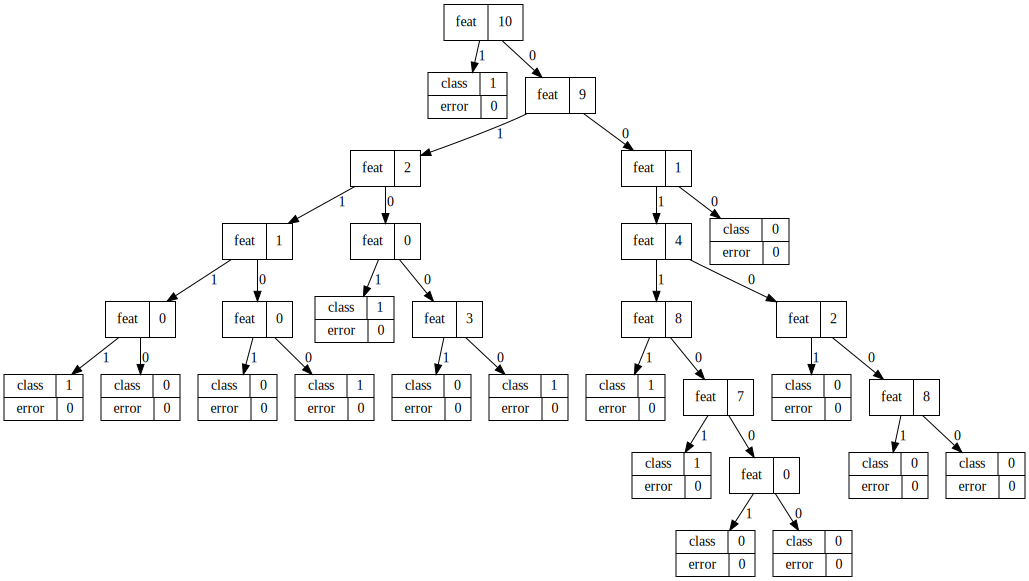

In [20]:
dot = clf.export_graphviz()
graphviz.Source(dot)

In [22]:
import uuid
from sklearn.exceptions import NotFittedError
from pydl85.errors.errors import TreeNotFoundError, SearchFailedError


def get_dot_body(treedict, parent=None, left=True):
    gstring = ""
    id = str(uuid.uuid4())
    id = id.replace('-', '_')

    if "feat" in treedict.keys():
        feat = treedict["feat"]
        if parent is None:
            gstring += "node_" + id + " [label=\"{{feat|" + str(feat) + "}}\"];\n"
            gstring += get_dot_body(treedict["left"], id)
            gstring += get_dot_body(treedict["right"], id, False)
        else:
            gstring += "node_" + id + " [label=\"{{feat|" + str(feat) + "}}\"];\n"
            gstring += "node_" + parent + " -> node_" + id + " [label=" + str(int(left)) + "];\n"
            gstring += get_dot_body(treedict["left"], id)
            gstring += get_dot_body(treedict["right"], id, False)
    else:
        val = str(int(treedict["value"])) if treedict["value"] - int(treedict["value"]) == 0 else str(
            round(treedict["value"], 3))
        err = str(int(treedict["error"])) if treedict["error"] - int(treedict["error"]) == 0 else str(
            round(treedict["error"], 3))
        values = str(treedict["values"])

        gstring += "leaf_" + id + " [label=\"{{class|" + val + "}|{error|" + err + "}|{values|" + values + "}}\"];\n"
        #+ "}|{true positive|" + true_pos + "}|{false positive|" + false_pos + "}|{true negative|" + true_neg + "}|{false negative|" + false_neg \

        gstring += "node_" + parent + " -> leaf_" + id + " [label=" + str(int(left)) + "];\n"
    return gstring


def export_graphviz(clf):
    if clf.is_fitted_ is False:  # fit method has not been called
        raise NotFittedError("Call fit method first" % {'name': type(clf).__name__})

    if clf.tree_ is None:
        raise TreeNotFoundError("predict(): ", "Tree not found during training by DL8.5 - "
                                               "Check fitting message for more info.")

    if hasattr(clf, 'tree_') is False:  # normally this case is not possible.
        raise SearchFailedError("PredictionError: ", "DL8.5 training has failed. Please contact the developers "
                                                     "if the problem is in the scope supported by the tool.")

    # initialize the header
    graph_string = "digraph Tree { \n " \
                   "graph [ranksep=0]; \n " \
                   "node [shape=record]; \n"

    # build the body
    graph_string += get_dot_body(clf.tree_)

    # end by the footer
    graph_string += "}"

    return graph_string

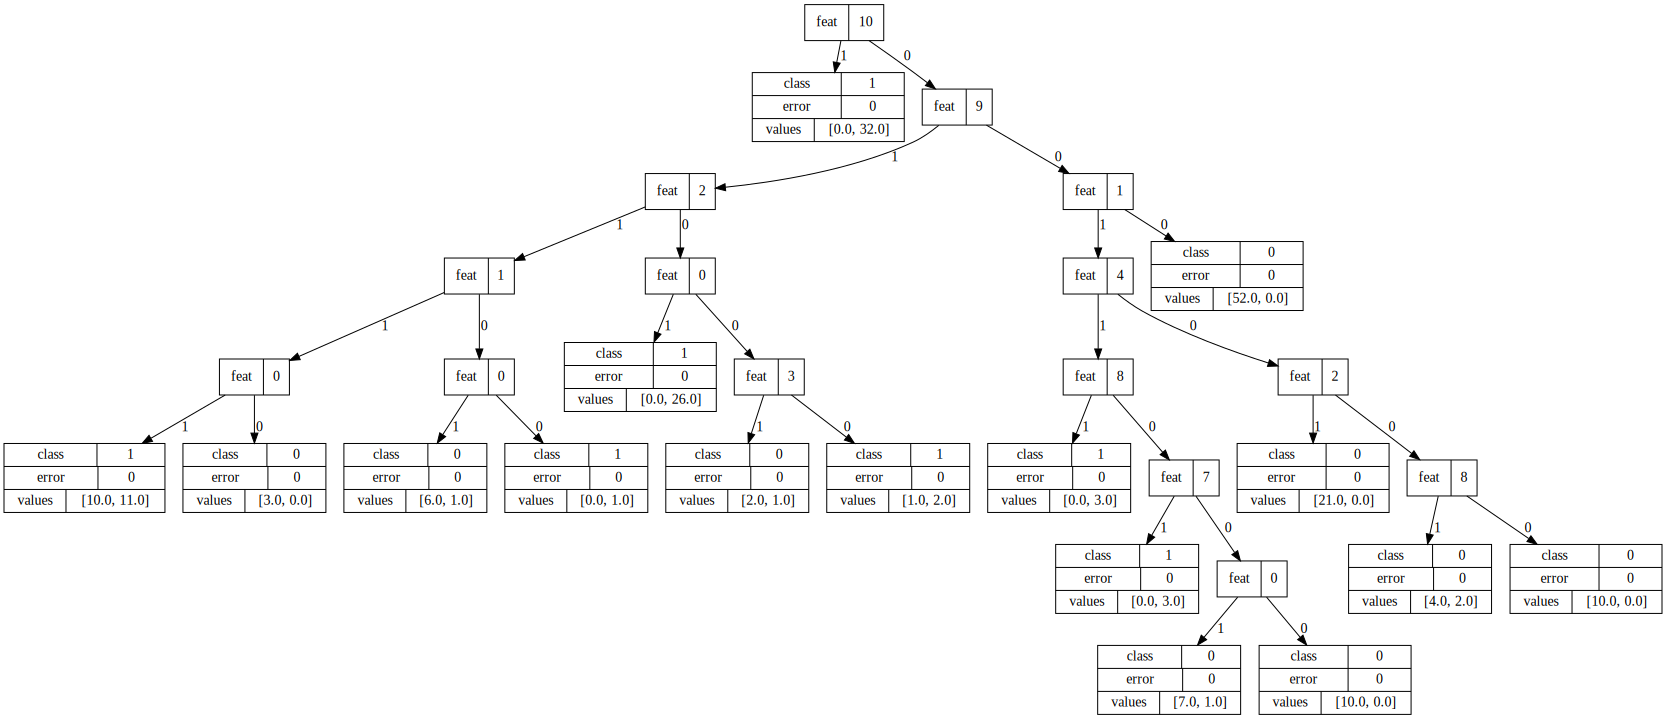

In [23]:
dot = export_graphviz(clf)
graphviz.Source(dot)

In [24]:
clf = DecisionTreeClassifier(max_depth=7, random_state=0)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),6)
discrimation_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 6)
leafs = list()
cnt = np.unique(sensitive, return_counts=True)[1]
relabeling_fairlearn.get_leaves_candidates(clf, X_train, y_train, sensitive_train, cnt, len(y_train), leafs)
leafs_relab = relabeling_fairlearn.leaves_to_relabel(clf, X_train, y_train, y_pred_train, sensitive_train, 0.1)
for leaf in leafs_relab:
    relabeling_fairlearn.browse_and_relab(clf, leaf.node_id)
y_pred_train = clf.predict(X_train)
accuracy_train_relab = round(accuracy_score(y_train, y_pred_train), 6)
discrimation_train_pred_relab = round(utils.discrimination(y_pred_train, sensitive_train), 6)
new_acc= round(accuracy_train+sum_acc, 6)
new_disc = round(discrimation_train_pred+sum_disc, 6)
print(f"Accuracy:\n"
      f"    Before      : {accuracy_train}\n"
      f"    Leafs       : {sum_acc}\n"
      f"    After       : {accuracy_train_relab}\n"
      f"    Expected    : {new_acc}\n"
      f"    Check       : {new_acc == accuracy_train_relab}")
print(f"Discrim:\n"
      f"    Before      : {discrimation_train_pred}\n"
      f"    Leafs       : {sum_disc }\n"
      f"    After       : {discrimation_train_pred_relab}\n"
      f"    Expected    : {new_disc}\n"
      f"    Check       : {new_disc== discrimation_train_pred_relab}")

Accuracy:
    Before      : 0.923445
    Leafs       : -0.148325
    After       : 0.77512
    Expected    : 0.77512
    Check       : True
Discrim:
    Before      : 0.294
    Leafs       : -0.25
    After       : 0.044
    Expected    : 0.044
    Check       : True


In [25]:
pydl = dict()
utils.sklearn_to_pydl(clf, pydl, 0)

In [26]:
clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
clf.tree_ = pydl
discrimation_train_pred_relab = round(utils.discrimination(y_pred_train, sensitive_train), 6)
new_acc= round(accuracy_train+sum_acc, 6)
new_disc = round(discrimation_train_pred+sum_disc, 6)
print(f"Accuracy:\n"
      f"    Before      : {accuracy_train}\n"
      f"    Leafs       : {sum_acc}\n"
      f"    After       : {accuracy_train_relab}\n"
      f"    Expected    : {new_acc}\n"
      f"    Check       : {new_acc == accuracy_train_relab}")
print(f"Discrim:\n"
      f"    Before      : {discrimation_train_pred}\n"
      f"    Leafs       : {sum_disc }\n"
      f"    After       : {discrimation_train_pred_relab}\n"
      f"    Expected    : {new_disc}\n"
      f"    Check       : {new_disc== discrimation_train_pred_relab}")

Accuracy:
    Before      : 0.923445
    Leafs       : -0.148325
    After       : 0.77512
    Expected    : 0.77512
    Check       : True
Discrim:
    Before      : 0.294
    Leafs       : -0.25
    After       : 0.277048
    Expected    : 0.044
    Check       : False
